# **Phase 1: Check and Install Libraries/Dependecies**

In [46]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  96
  On-line CPU(s) list:   0-95
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) CPU @ 2.00GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  24
    Socket(s):           2
    Stepping:            3
    BogoMIPS:            4000.34
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscal
                         l nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopo
                         logy nonstop_tsc cpuid tsc_known_freq pni pclmulqdq sss
                         e3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes 
                         xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowp

In [47]:
!pip install --upgrade scikit-learn imbalanced-learn
!pip install shap
!pip install optuna


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [48]:
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pprint as pp
import time
from scipy.stats import skew
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from datetime import datetime

warnings.filterwarnings('ignore')

In [49]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [50]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


# **Phase 2: Load & Clean Data**

In [51]:
# Path to the dataset directory
data_dir = '/kaggle/input/ton-iot-weatherandnetwork/'
print("Loading data files...")

# Find all IoT and Network files
iot_files = glob.glob(os.path.join(data_dir, 'IoT_*.csv'))
network_files = glob.glob(os.path.join(data_dir, 'Network_*.csv'))
print(f"Found {len(iot_files)} IoT files")
print(f"Found {len(network_files)} Network files")

# --- IoT Data Processing ---
print("\n--- Processing IoT Data ---")
iot_dataframes = []
common_timestamp_column = 'timestamp'  # Will be used as the key for merging

for file_path in iot_files:
    filename = os.path.basename(file_path)
    print(f"Loading {filename}...")
    
    # Use error_bad_lines=False to skip problematic rows
    df = pd.read_csv(file_path, low_memory=False)
    
    # Create timestamp column if needed
    if 'date' in df.columns and 'time' in df.columns:
        print(f"  Creating timestamp from date and time columns in {filename}")
        df[common_timestamp_column] = pd.to_datetime(df['date'] + ' ' + df['time'], errors='coerce')
        df.drop(columns=['date', 'time'], inplace=True, errors='ignore')
    elif 'ts' in df.columns:
        print(f"  Converting ts to timestamp in {filename}")
        df[common_timestamp_column] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
    elif common_timestamp_column not in df.columns:
        print(f"  Warning: No timestamp data found in {filename}, skipping file")
        continue
    
    # Drop rows with null timestamps
    before_drop = len(df)
    df = df.dropna(subset=[common_timestamp_column])
    if before_drop > len(df):
        print(f"  Removed {before_drop - len(df)} rows with null timestamps")
    
    # Sort by timestamp - critical for merge_asof
    df = df.sort_values(common_timestamp_column)
    
    # Create a filename-based prefix for columns to avoid duplicates during merging
    prefix = os.path.splitext(filename)[0].replace('IoT_', '')
    # Skip prefixing the timestamp column
    columns_to_rename = [col for col in df.columns if col != common_timestamp_column]
    df = df.rename(columns={col: f"{prefix}_{col}" for col in columns_to_rename})
    
    # Handle NaN values with more robust approach
    # Use interpolation for numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    df[numeric_cols] = df[numeric_cols].interpolate(method='linear', limit_direction='both')
    
    # Forward fill for remaining columns (may include categorical data)
    df = df.fillna(method='ffill')
    # Backward fill any remaining NaNs at the beginning
    df = df.fillna(method='bfill')
    
    print(f"  Processed {filename}: {df.shape[0]} rows, {df.shape[1]} columns")
    iot_dataframes.append(df)

# Merge IoT datasets using merge_asof for time-based alignment
if iot_dataframes:
    if len(iot_dataframes) == 1:
        print("\nOnly one IoT dataset found, no merging needed")
        iot_df = iot_dataframes[0]
    else:
        print(f"\nMerging {len(iot_dataframes)} IoT datasets on nearest timestamps...")
        # Sort dataframes by size (smallest to largest) for more efficient merging
        iot_dataframes.sort(key=lambda x: len(x))
        
        # Start with the largest dataframe
        iot_df = iot_dataframes.pop()
        
        # Merge with each remaining dataframe one by one
        for i, next_df in enumerate(iot_dataframes):
            print(f"  Merging dataset {i+1}/{len(iot_dataframes)}")
            
            # Ensure both dataframes have the timestamp column as datetime
            iot_df[common_timestamp_column] = pd.to_datetime(iot_df[common_timestamp_column])
            next_df[common_timestamp_column] = pd.to_datetime(next_df[common_timestamp_column])
            
            # Merge on nearest timestamp
            iot_df = pd.merge_asof(
                iot_df,
                next_df,
                on=common_timestamp_column,
                direction='nearest',
                tolerance=pd.Timedelta('5min')  # Add reasonable tolerance
            )
            
            # Report on the merge
            print(f"    Current merged dataset: {iot_df.shape[0]} rows, {iot_df.shape[1]} columns")
    
    print(f"\nFinal IoT Dataset: {iot_df.shape[0]} rows, {iot_df.shape[1]} columns")
    
    # Handle any remaining NaN values in the final merged dataset
    if iot_df.isna().any().any():
        before_impute = iot_df.isna().sum().sum()
        
        # Use more sophisticated imputation for numeric columns
        numeric_cols = iot_df.select_dtypes(include=[np.number]).columns
        iot_df[numeric_cols] = iot_df[numeric_cols].interpolate(method='linear', limit_direction='both')
        
        # Forward fill for remaining non-numeric columns
        non_numeric_cols = [col for col in iot_df.columns if col not in numeric_cols and col != common_timestamp_column]
        if non_numeric_cols:
            iot_df[non_numeric_cols] = iot_df[non_numeric_cols].fillna(method='ffill').fillna(method='bfill')
            
        after_impute = iot_df.isna().sum().sum()
        print(f"  Imputed {before_impute - after_impute} missing values in merged dataset")
        
        # If any NaNs remain, fill with column means/modes as last resort
        if iot_df.isna().any().any():
            for col in iot_df.columns:
                if col == common_timestamp_column:
                    continue
                if iot_df[col].isna().any():
                    if pd.api.types.is_numeric_dtype(iot_df[col]):
                        iot_df[col].fillna(iot_df[col].mean(), inplace=True)
                    else:
                        iot_df[col].fillna(iot_df[col].mode()[0] if not iot_df[col].mode().empty else "UNKNOWN", inplace=True)
            print(f"  Used mean/mode imputation for remaining missing values")
    
    # Ensure the dataset is sorted by timestamp
    iot_df = iot_df.sort_values(common_timestamp_column).reset_index(drop=True)
    
else:
    print("No valid IoT datasets found")
    iot_df = pd.DataFrame()

# --- Network Data Processing ---
print("\n--- Processing Network Data ---")
network_dataframes = []

for file_path in network_files:
    filename = os.path.basename(file_path)
    print(f"Loading {filename}...")
    
    df = pd.read_csv(file_path, low_memory=False)
    
    # Ensure timestamp column exists
    if 'ts' in df.columns:
        print(f"  Converting ts to timestamp in {filename}")
        df[common_timestamp_column] = pd.to_datetime(df['ts'], unit='s', errors='coerce')
    elif common_timestamp_column not in df.columns:
        print(f"  Warning: No timestamp data found in {filename}, skipping file")
        continue
        
    # Drop rows with null timestamps
    before_drop = len(df)
    df = df.dropna(subset=[common_timestamp_column])
    if before_drop > len(df):
        print(f"  Removed {before_drop - len(df)} rows with null timestamps")
    
    # Handle NaNs
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    print(f"  Processed {filename}: {df.shape[0]} rows, {df.shape[1]} columns")
    network_dataframes.append(df)

if network_dataframes:
    # Concatenate network dataframes
    network_df = pd.concat(network_dataframes, ignore_index=True)
    
    # Remove duplicates based on timestamp
    before_dedup = len(network_df)
    network_df = network_df.drop_duplicates(subset=common_timestamp_column).copy()
    if before_dedup > len(network_df):
        print(f"  Removed {before_dedup - len(network_df)} duplicate timestamp rows from Network data")
    
    # Ensure the dataset is sorted by timestamp
    network_df = network_df.sort_values(common_timestamp_column).reset_index(drop=True)
    
    print(f"\nFinal Network Dataset: {network_df.shape[0]} rows, {network_df.shape[1]} columns")
else:
    print("No valid Network datasets found")
    network_df = pd.DataFrame()

Loading data files...
Found 7 IoT files
Found 23 Network files

--- Processing IoT Data ---
Loading IoT_Garage_Door.csv...
  Creating timestamp from date and time columns in IoT_Garage_Door.csv
  Removed 21335 rows with null timestamps
  Processed IoT_Garage_Door.csv: 570111 rows, 5 columns
Loading IoT_Modbus.csv...
  Creating timestamp from date and time columns in IoT_Modbus.csv
  Processed IoT_Modbus.csv: 287194 rows, 7 columns
Loading IoT_Motion_Light.csv...
  Creating timestamp from date and time columns in IoT_Motion_Light.csv
  Processed IoT_Motion_Light.csv: 452262 rows, 5 columns
Loading IoT_GPS_Tracker.csv...
  Creating timestamp from date and time columns in IoT_GPS_Tracker.csv
  Processed IoT_GPS_Tracker.csv: 595686 rows, 5 columns
Loading IoT_Weather.csv...
  Creating timestamp from date and time columns in IoT_Weather.csv
  Processed IoT_Weather.csv: 650242 rows, 6 columns
Loading IoT_Fridge.csv...
  Creating timestamp from date and time columns in IoT_Fridge.csv
  Proces

In [52]:
print(f"IoT Dataset \n {iot_df.info()}")
print(iot_df.head(10))

print(f"Network Dataset \n {network_df.info()}")
print(network_df.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 650242 entries, 0 to 650241
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Weather_temperature               650242 non-null  float64       
 1   Weather_pressure                  650242 non-null  float64       
 2   Weather_humidity                  650242 non-null  float64       
 3   Weather_label                     650242 non-null  int64         
 4   Weather_type                      650242 non-null  object        
 5   timestamp                         650242 non-null  datetime64[ns]
 6   Modbus_FC1_Read_Input_Register    650242 non-null  float64       
 7   Modbus_FC2_Read_Discrete_Value    650242 non-null  float64       
 8   Modbus_FC3_Read_Holding_Register  650242 non-null  float64       
 9   Modbus_FC4_Read_Coil              650242 non-null  float64       
 10  Modbus_label                    

In [53]:
# After the IoT datasets have been merged and processed
# This code should be added after the final iot_df is created

print("Consolidating multiple label and type columns into single columns...")

# Check if iot_df is not empty
if not iot_df.empty:
    # 1. First identify all label and type columns
    label_columns = [col for col in iot_df.columns if col.endswith('_label')]
    type_columns = [col for col in iot_df.columns if col.endswith('_type')]
    
    print(f"Found {len(label_columns)} label columns: {label_columns}")
    print(f"Found {len(type_columns)} type columns: {type_columns}")
    
    # 2. Check if the labels are consistent
    if len(label_columns) > 1:
        for i in range(1, len(label_columns)):
            comparison_col = label_columns[0]
            current_col = label_columns[i]
            # Count mismatches
            mismatches = (iot_df[comparison_col] != iot_df[current_col]).sum()
            print(f"Mismatches between {comparison_col} and {current_col}: {mismatches}")
    
    # 5. Alternative approach: if labels must match across all sources
    # This follows your reference code example
    
    # First, check if there are any mismatches among the label columns
    mismatches_exist = False
    for i in range(1, len(label_columns)):
        if (iot_df[label_columns[0]] != iot_df[label_columns[i]]).any():
            mismatches_exist = True
            break
    
    # Process based on whether mismatches exist
    if mismatches_exist:
        print("\nUsing strict label consistency approach...")
        # Create conditions to check if all labels match
        matching_labels = True
        for i in range(1, len(label_columns)):
            matching_labels = matching_labels & (iot_df[label_columns[0]] == iot_df[label_columns[i]])
        
        # Keep only rows where all labels match
        before_filter = len(iot_df)
        iot_df = iot_df[matching_labels].copy()
        after_filter = len(iot_df)
        print(f"Filtered out {before_filter - after_filter} rows with inconsistent labels")
    
    # 3. Create consolidated label column (using the first label column)
    if label_columns:
        iot_df['label'] = iot_df[label_columns[0]]
        # Drop the original label columns
        iot_df.drop(columns=label_columns, inplace=True)
        print(f"Created consolidated 'label' column")
    
    # 4. Create consolidated type column (using the first type column)
    if type_columns:
        iot_df['type'] = iot_df[type_columns[0]]
        # Drop the original type columns
        iot_df.drop(columns=type_columns, inplace=True)
        print(f"Created consolidated 'type' column")
    
    # This block has been removed as it's now handled earlier in the code
    
    print(f"\nFinal IoT Dataset after consolidation: {iot_df.shape[0]} rows, {iot_df.shape[1]} columns")
    
    # Display the first few rows to verify the result
    print("\nFirst few rows of the consolidated dataset:")
    print(iot_df.head().to_string())
    
    # Check if 'label' column exists in the final dataframe
    if 'label' in iot_df.columns:
        print("\nLabel distribution:")
        print(iot_df['label'].value_counts())
    
    if 'type' in iot_df.columns:
        print("\nType distribution:")
        print(iot_df['type'].value_counts())
else:
    print("Empty IoT dataframe, no consolidation performed")

Consolidating multiple label and type columns into single columns...
Found 7 label columns: ['Weather_label', 'Modbus_label', 'Thermostat_label', 'Motion_Light_label', 'Garage_Door_label', 'Fridge_label', 'GPS_Tracker_label']
Found 7 type columns: ['Weather_type', 'Modbus_type', 'Thermostat_type', 'Motion_Light_type', 'Garage_Door_type', 'Fridge_type', 'GPS_Tracker_type']
Mismatches between Weather_label and Modbus_label: 19320
Mismatches between Weather_label and Thermostat_label: 27357
Mismatches between Weather_label and Motion_Light_label: 2526
Mismatches between Weather_label and Garage_Door_label: 11627
Mismatches between Weather_label and Fridge_label: 2235
Mismatches between Weather_label and GPS_Tracker_label: 1324

Using strict label consistency approach...
Filtered out 42841 rows with inconsistent labels
Created consolidated 'label' column
Created consolidated 'type' column

Final IoT Dataset after consolidation: 607401 rows, 20 columns

First few rows of the consolidated da

In [54]:
# Sort BOTH DataFrames by 'timestamp' and assign back
iot_df = iot_df.sort_values('timestamp').reset_index(drop=True)
network_df = network_df.sort_values('timestamp').reset_index(drop=True)

# Merge with asof on timestamp (nearest matching)
merged_df = pd.merge_asof(iot_df, network_df, on='timestamp', direction='nearest')

merged_df.head(10)

,Weather_temperature,Weather_pressure,Weather_humidity,timestamp,Modbus_FC1_Read_Input_Register,Modbus_FC2_Read_Discrete_Value,Modbus_FC3_Read_Holding_Register,Modbus_FC4_Read_Coil,Thermostat_current_temperature,Thermostat_thermostat_status,...,http_status_code,http_user_agent,http_orig_mime_types,http_resp_mime_types,weird_name,weird_addl,weird_notice,label_y,type_y,uid
0,31.788508,1.035,32.036579,2019-03-31 12:36:52,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
1,31.788508,1.035,32.036579,2019-03-31 12:36:52,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
2,41.630997,1.035,30.886165,2019-03-31 12:36:53,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
3,41.630997,1.035,30.886165,2019-03-31 12:36:53,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
4,42.256959,1.035,19.755908,2019-03-31 12:36:54,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
5,42.256959,1.035,19.755908,2019-03-31 12:36:54,11287.0,3537.0,27844.0,30527.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
6,49.116581,1.035,78.949621,2019-03-31 12:36:55,53287.0,1463.0,33518.0,23014.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
7,49.116581,1.035,78.949621,2019-03-31 12:36:55,53287.0,1463.0,33518.0,23014.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
8,24.017085,1.035,40.001059,2019-03-31 12:36:56,53287.0,1463.0,33518.0,23014.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN
9,24.017085,1.035,40.001059,2019-03-31 12:36:56,53287.0,1463.0,33518.0,23014.0,25.0,0.0,...,0,-,-,-,bad_TCP_checksum,-,F,0,normal,NaN


In [55]:
# --- Display Summary Info ---
print("\n--- Dataset Summary ---")
if not iot_df.empty:
    print(f"IoT Dataset: {iot_df.shape[0]} rows, {iot_df.shape[1]} columns")
    print(f"IoT columns: {', '.join(iot_df.columns[:10])}{'...' if len(iot_df.columns) > 10 else ''}")
    print(f"IoT timestamp range: {iot_df[common_timestamp_column].min()} to {iot_df[common_timestamp_column].max()}")

if not network_df.empty:
    print(f"\nNetwork Dataset: {network_df.shape[0]} rows, {network_df.shape[1]} columns")
    print(f"Network columns: {', '.join(network_df.columns[:10])}{'...' if len(network_df.columns) > 10 else ''}")
    print(f"Network timestamp range: {network_df[common_timestamp_column].min()} to {network_df[common_timestamp_column].max()}")

if 'merged_df' in locals() and not merged_df.empty:
    print(f"\nMerged Dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")
    missing_values = merged_df.isna().sum().sum()
    print(f"Missing values in merged dataset: {missing_values}")


--- Dataset Summary ---
IoT Dataset: 607401 rows, 20 columns
IoT columns: Weather_temperature, Weather_pressure, Weather_humidity, timestamp, Modbus_FC1_Read_Input_Register, Modbus_FC2_Read_Discrete_Value, Modbus_FC3_Read_Holding_Register, Modbus_FC4_Read_Coil, Thermostat_current_temperature, Thermostat_thermostat_status...
IoT timestamp range: 2019-03-31 12:36:52 to 2019-04-29 14:47:38

Network Dataset: 392633 rows, 48 columns
Network columns: ts, src_ip, src_port, dst_ip, dst_port, proto, service, duration, src_bytes, dst_bytes...
Network timestamp range: 2019-04-02 09:45:58 to 2019-04-29 14:45:56

Merged Dataset: 607401 rows, 67 columns
Missing values in merged dataset: 607401


In [56]:
train_df = merged_df

print(train_df['type_x'].unique())
print(train_df['type_y'].unique())

['normal' 'injection' 'ddos' 'password' 'xss' 'backdoor']
['normal' 'scanning' 'injection' 'ddos' 'password' 'xss' 'backdoor' 'mitm']


In [57]:
print("dataset shape: ",train_df.shape)

dataset shape:  (607401, 67)


In [58]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 607401 entries, 0 to 607400
Data columns (total 67 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Weather_temperature               607401 non-null  float64       
 1   Weather_pressure                  607401 non-null  float64       
 2   Weather_humidity                  607401 non-null  float64       
 3   timestamp                         607401 non-null  datetime64[ns]
 4   Modbus_FC1_Read_Input_Register    607401 non-null  float64       
 5   Modbus_FC2_Read_Discrete_Value    607401 non-null  float64       
 6   Modbus_FC3_Read_Holding_Register  607401 non-null  float64       
 7   Modbus_FC4_Read_Coil              607401 non-null  float64       
 8   Thermostat_current_temperature    607401 non-null  float64       
 9   Thermostat_thermostat_status      607401 non-null  float64       
 10  Motion_Light_motion_status      

In [59]:
# Identify the data types of columns
column_data_types = train_df.dtypes

# Count the numerical and categorical columns
numerical_count = 0
categorical_count = 0

for column_name, data_type in column_data_types.items():
    if np.issubdtype(data_type, np.number):
        numerical_count += 1
    else:
        categorical_count += 1

# Print the counts
print(f"There are {numerical_count} Numerical Columns in dataset")
print(f"There are {categorical_count} Categorical Columns in dataset")

There are 31 Numerical Columns in dataset
There are 36 Categorical Columns in dataset


In [60]:
missing_data = train_df.isnull().sum().to_frame().rename(columns={0:"Total No. of Missing Values"})
missing_data["% of Missing Values"] = round((missing_data["Total No. of Missing Values"]/len(train_df))*100,2)
missing_data

,Total No. of Missing Values,% of Missing Values
Weather_temperature,0,0.0
Weather_pressure,0,0.0
Weather_humidity,0,0.0
timestamp,0,0.0
Modbus_FC1_Read_Input_Register,0,0.0
...,...,...
weird_addl,0,0.0
weird_notice,0,0.0
label_y,0,0.0
type_y,0,0.0


**Descriptive Analysis**

In [ ]:
round(train_df.describe().T,2)

,count,mean,min,25%,50%,75%,max,std
Weather_temperature,607401.0,36.103742,20.507282,29.087407,36.854045,43.153073,50.0,8.211344
Weather_pressure,607401.0,2.061551,-37.632097,0.176807,1.298459,4.000048,26.685611,7.86135
Weather_humidity,607401.0,51.682434,0.000162,28.520181,52.707818,74.825978,99.889498,27.103047
timestamp,607401,2019-04-08 14:10:39.304987904,2019-03-31 12:36:52,2019-04-02 04:08:05,2019-04-02 10:42:46,2019-04-04 07:40:16,2019-04-29 14:47:38,NaN
Modbus_FC1_Read_Input_Register,607401.0,28955.569497,0.0,14078.133151,27905.0,42388.0,65533.0,17850.79571
Modbus_FC2_Read_Discrete_Value,607401.0,28842.057513,0.0,13128.0,27886.0,41683.0,65534.0,17965.049829
Modbus_FC3_Read_Holding_Register,607401.0,32186.230612,0.0,15190.0,32071.0,49327.0,65531.0,18975.88608
Modbus_FC4_Read_Coil,607401.0,30246.64192,0.0,15159.651631,29748.0,43004.0,65535.0,17835.157029
Thermostat_current_temperature,607401.0,28.605804,25.0,26.704138,28.273475,30.199036,34.996024,2.321702
Thermostat_thermostat_status,607401.0,0.882735,0.0,1.0,1.0,1.0,1.0,0.316101


In [62]:
train_df.describe(include="O").T

,count,unique,top,freq
Motion_Light_light_status,607401,2,off,371882
Garage_Door_door_state,607401,2,closed,548952
Garage_Door_sphone_signal,607401,4,false,360746
Fridge_temp_condition,607401,6,high,188396
type_x,607401,6,normal,530796
src_ip,607401,147,3.122.49.24,303024
dst_ip,607401,615,192.168.1.152,376044
proto,607401,3,tcp,543678
service,607401,9,-,520064
src_bytes,607401,3109,1762852,303019


In [63]:
(train_df['label_x'] != train_df['label_y']).sum()

np.int64(72500)

In [64]:
# Keep only rows where labels match
train_df = train_df[train_df['label_x'] == train_df['label_y']].copy()

In [65]:
# Rename and drop duplicates
train_df['label'] = train_df['label_y']
train_df['type'] = train_df['type_y']
train_df.drop(columns=['label_x', 'label_y', 'type_x', 'type_y'], inplace=True)

In [66]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534901 entries, 0 to 607400
Data columns (total 65 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Weather_temperature               534901 non-null  float64       
 1   Weather_pressure                  534901 non-null  float64       
 2   Weather_humidity                  534901 non-null  float64       
 3   timestamp                         534901 non-null  datetime64[ns]
 4   Modbus_FC1_Read_Input_Register    534901 non-null  float64       
 5   Modbus_FC2_Read_Discrete_Value    534901 non-null  float64       
 6   Modbus_FC3_Read_Holding_Register  534901 non-null  float64       
 7   Modbus_FC4_Read_Coil              534901 non-null  float64       
 8   Thermostat_current_temperature    534901 non-null  float64       
 9   Thermostat_thermostat_status      534901 non-null  float64       
 10  Motion_Light_motion_status        534

In [67]:
# Print class distribution before resampling
print("Before resampling:", train_df['type'].value_counts())

Before resampling: type
normal       461794
backdoor      33372
password      16643
ddos          13989
injection      8348
xss             755
Name: count, dtype: int64


# **Phase 3: Feature Engineering and Selection**

In [68]:
# Display all unique problematic values in src_bytes
invalid_src_bytes = train_df[pd.to_numeric(train_df['src_bytes'], errors='coerce').isna()]
print(invalid_src_bytes['src_bytes'].value_counts())

src_bytes
0.0.0.0    39
Name: count, dtype: int64


In [69]:
def generate_features_ton_iot(df):

    df['src_bytes'] = df['src_bytes'].replace("0.0.0.0", "0")
    df['src_bytes'] = pd.to_numeric(df['src_bytes'], errors='coerce')

    
    # =====================
    # RATIO FEATURES
    # =====================
    df['byte_ratio'] = df['src_bytes'] / (df['dst_bytes'] + 1)
    df['pkt_ratio'] = df['src_pkts'] / (df['dst_pkts'] + 1)
    df['ip_byte_ratio'] = df['src_ip_bytes'] / (df['dst_ip_bytes'] + 1)
    df['duration_per_pkt'] = df['duration'] / (df['src_pkts'] + df['dst_pkts'] + 1)
    
    # =====================
    # AGGREGATE FEATURES
    # =====================
    df['total_bytes'] = df['src_bytes'] + df['dst_bytes']
    df['total_pkts'] = df['src_pkts'] + df['dst_pkts']
    df['total_ip_bytes'] = df['src_ip_bytes'] + df['dst_ip_bytes']
    
    # =====================
    # INTERACTION FEATURES
    # =====================
    df['byte_pkt_interaction_src'] = df['src_bytes'] * df['src_pkts']
    df['byte_pkt_interaction_dst'] = df['dst_bytes'] * df['dst_pkts']
    df['ipbyte_pkt_interaction_src'] = df['src_ip_bytes'] * df['src_pkts']
    df['ipbyte_pkt_interaction_dst'] = df['dst_ip_bytes'] * df['dst_pkts']

    # # =====================
    # # SENSOR FEATURE TRANSFORMATIONS (IoT)
    # # =====================
    # df['temp_humidity_interaction'] = df['temperature'] * df['humidity']
    # df['temp_pressure_ratio'] = df['temperature'] / (df['pressure'] + 1)
    
    # =====================
    # OPTIONAL: Replace infinities and NaNs
    # =====================
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(df.median(numeric_only=True))

    return df

generate_features_ton_iot(train_df)

,Weather_temperature,Weather_pressure,Weather_humidity,timestamp,Modbus_FC1_Read_Input_Register,Modbus_FC2_Read_Discrete_Value,Modbus_FC3_Read_Holding_Register,Modbus_FC4_Read_Coil,Thermostat_current_temperature,Thermostat_thermostat_status,...,pkt_ratio,ip_byte_ratio,duration_per_pkt,total_bytes,total_pkts,total_ip_bytes,byte_pkt_interaction_src,byte_pkt_interaction_dst,ipbyte_pkt_interaction_src,ipbyte_pkt_interaction_dst
0,31.788508,1.035000,32.036579,2019-03-31 12:36:52,11287.0,3537.0,27844.0,30527.0,25.000000,0.0,...,84060.333333,62916.270042,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472
1,31.788508,1.035000,32.036579,2019-03-31 12:36:52,11287.0,3537.0,27844.0,30527.0,25.000000,0.0,...,84060.333333,62916.270042,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472
2,41.630997,1.035000,30.886165,2019-03-31 12:36:53,11287.0,3537.0,27844.0,30527.0,25.000000,0.0,...,84060.333333,62916.270042,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472
3,41.630997,1.035000,30.886165,2019-03-31 12:36:53,11287.0,3537.0,27844.0,30527.0,25.000000,0.0,...,84060.333333,62916.270042,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472
4,42.256959,1.035000,19.755908,2019-03-31 12:36:54,11287.0,3537.0,27844.0,30527.0,25.000000,0.0,...,84060.333333,62916.270042,0.319408,43696067,252183,14911392,444557780212,83866430,3760310231236,472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
607396,44.231998,2.495434,95.049929,2019-04-29 14:47:31,33253.0,58690.0,3365.0,50997.0,30.484293,1.0,...,3.333333,10.814815,0.001860,226,12,956,2260,0,8760,160
607397,36.771845,1.155912,25.337601,2019-04-29 14:47:33,33253.0,58690.0,3365.0,50997.0,30.068230,1.0,...,3.333333,10.814815,0.001860,226,12,956,2260,0,8760,160
607398,47.943151,1.783286,48.870661,2019-04-29 14:47:35,18054.0,7503.0,23519.0,45920.0,30.068230,1.0,...,3.333333,10.814815,0.001860,226,12,956,2260,0,8760,160
607399,44.573469,2.495434,95.049929,2019-04-29 14:47:36,18054.0,7503.0,23519.0,45920.0,29.722941,1.0,...,3.333333,10.814815,0.001860,226,12,956,2260,0,8760,160


In [70]:
# # Columns to drop explicitly - Binary Classification
# selected_cols = ['src_ip', 'dst_ip',
#                  'src_port', 'dst_port', 'uid', 'ts',
#                  'proto', 'service', 'type']

# Columns to drop explicitly - Multi-Class Classification
selected_cols = ['src_ip', 'dst_ip',
                 'src_port', 'dst_port', 'uid', 'ts',
                 'proto', 'service', 'label']

# Auto-detected based on prefix
dns_cols = [col for col in train_df.columns if col.startswith('dns_')]
ssl_cols = [col for col in train_df.columns if col.startswith('ssl_')]
http_cols = [col for col in train_df.columns if col.startswith('http_')]
weird_cols = [col for col in train_df.columns if col.startswith('weird_')]

# Combine all columns to drop
columns_to_drop = selected_cols + dns_cols + ssl_cols + http_cols + weird_cols

# Drop from DataFrame
train_df.drop(columns=columns_to_drop, inplace=True)

In [71]:
train_df['hour'] = train_df['timestamp'].dt.hour
train_df['minute'] = train_df['timestamp'].dt.minute
train_df['second'] = train_df['timestamp'].dt.second

train_df['hour_sin'] = np.sin(2 * np.pi * train_df['hour'] / 24)
train_df['hour_cos'] = np.cos(2 * np.pi * train_df['hour'] / 24)

train_df['minute_sin'] = np.sin(2 * np.pi * train_df['minute'] / 60)
train_df['minute_cos'] = np.cos(2 * np.pi * train_df['minute'] / 60)

train_df['second_sin'] = np.sin(2 * np.pi * train_df['second'] / 60)
train_df['second_cos'] = np.cos(2 * np.pi * train_df['second'] / 60)

train_df = train_df.drop(columns=['hour', 'minute', 'second', 'timestamp'])

In [72]:
# # To keep specific values within the 'attack_cat' column
# values_to_keep = ['normal', 'ddos', 'scanning', 'password']

# # Filter the rows where 'attack_cat' is in values_to_keep
# train_df = train_df[train_df['type'].isin(values_to_keep)]

print(train_df['type'].value_counts())
print("Total: ",train_df['type'].count())

type
normal       461794
backdoor      33372
password      16643
ddos          13989
injection      8348
xss             755
Name: count, dtype: int64
Total:  534901


In [73]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534901 entries, 0 to 607400
Data columns (total 44 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Weather_temperature               534901 non-null  float64
 1   Weather_pressure                  534901 non-null  float64
 2   Weather_humidity                  534901 non-null  float64
 3   Modbus_FC1_Read_Input_Register    534901 non-null  float64
 4   Modbus_FC2_Read_Discrete_Value    534901 non-null  float64
 5   Modbus_FC3_Read_Holding_Register  534901 non-null  float64
 6   Modbus_FC4_Read_Coil              534901 non-null  float64
 7   Thermostat_current_temperature    534901 non-null  float64
 8   Thermostat_thermostat_status      534901 non-null  float64
 9   Motion_Light_motion_status        534901 non-null  float64
 10  Motion_Light_light_status         534901 non-null  object 
 11  Garage_Door_door_state            534901 non-null  object

In [74]:
# # Binary Classification
# print("\n=== ENCODING ATTACK LABELS ===")
# label_mapping = {'Normal': 0, 'Attack': 1}
# print("Label Mapping:")
# print(label_mapping)
# print(train_df['label'].value_counts())

# First, inspect the categorical columns to understand their actual values
print("=== COLUMN INSPECTION BEFORE ENCODING ===")
categorical_columns = [
    'Motion_Light_light_status',
    'Garage_Door_door_state', 
    'Garage_Door_sphone_signal',
    'Fridge_temp_condition',
    'conn_state',
    'type'
]

for col in categorical_columns:
    if col in train_df.columns:
        print(f"\nValues in {col}:")
        print(train_df[col].value_counts().head(10))  # Show top 10 most common values
    else:
        print(f"\nColumn '{col}' not found in the dataset!")
        # Check for similar column names
        similar_cols = [c for c in train_df.columns if col.lower() in c.lower()]
        if similar_cols:
            print(f"Similar column names found: {similar_cols}")

# Multi-Class Classification for attack type
print("\n=== ENCODING ATTACK TYPES ===")
label_encoder = LabelEncoder()
train_df['type'] = label_encoder.fit_transform(train_df['type'])
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:")
print(label_mapping)
print(train_df['type'].value_counts())

# ROBUST ENCODING FUNCTION
def encode_categorical_column(df, column_name, mapping, unknown_value=-1):
    """
    Robustly encode a categorical column with proper error handling
    """
    if column_name not in df.columns:
        print(f"WARNING: Column '{column_name}' not found in the dataframe!")
        return df
    
    # Save original values for comparison
    original_values = df[column_name].value_counts()
    print(f"\nOriginal values in {column_name}:")
    print(original_values.head(10))
    
    # Standardize the values
    df[column_name] = df[column_name].astype(str).str.lower().str.strip()
    
    # Apply mapping
    df[column_name] = df[column_name].map(mapping)
    
    # Count NaN values after mapping
    nan_count = df[column_name].isna().sum()
    if nan_count > 0:
        print(f"WARNING: {nan_count} values in '{column_name}' couldn't be mapped!")
        print("Sample unmapped values:")
        unmapped_values = df[df[column_name].isna()][column_name].head()
        print(unmapped_values)
        
        # Fill NaN values with the unknown_value
        df[column_name] = df[column_name].fillna(unknown_value)
    
    # Show the result
    print(f"After encoding {column_name}:")
    print(df[column_name].value_counts())
    
    return df

# Encode door state
print("\n=== ENCODING DOOR STATE ===")
doors_mapping = {'closed': 0, 'open': 1}
train_df = encode_categorical_column(train_df, 'Garage_Door_door_state', doors_mapping)

# Encode sphone signal
print("\n=== ENCODING SPHONE SIGNAL ===")
# First, handle special cases
if 'Garage_Door_sphone_signal' in train_df.columns:
    train_df['Garage_Door_sphone_signal'] = train_df['Garage_Door_sphone_signal'].astype(str).str.lower().str.strip()
    train_df['Garage_Door_sphone_signal'] = train_df['Garage_Door_sphone_signal'].replace({
        '0': 'false', '0.0': 'false', 'false': 'false', 
        '1': 'true', '1.0': 'true', 'true': 'true'
    })
    
sphonesig_mapping = {'false': 0, 'true': 1}
train_df = encode_categorical_column(train_df, 'Garage_Door_sphone_signal', sphonesig_mapping)

# Encode light status
print("\n=== ENCODING LIGHT STATUS ===")
light_status_mapping = {'off': 0, 'on': 1}
train_df = encode_categorical_column(train_df, 'Motion_Light_light_status', light_status_mapping)

# Encode temperature condition
print("\n=== ENCODING TEMPERATURE CONDITION ===")
temp_condition_mapping = {'low': 0, 'high': 1}
train_df = encode_categorical_column(train_df, 'Fridge_temp_condition', temp_condition_mapping)

# One-hot encode conn_state
print("\n=== ONE-HOT ENCODING CONN_STATE ===")
if 'conn_state' in train_df.columns:
    print("Values in conn_state before encoding:")
    print(train_df['conn_state'].value_counts())
    train_df = pd.get_dummies(train_df, columns=['conn_state'], drop_first=False)
else:
    print("WARNING: 'conn_state' column not found!")

# Print final dataframe info
print("\n=== FINAL DATAFRAME INFO ===")
train_df.info()

=== COLUMN INSPECTION BEFORE ENCODING ===

Values in Motion_Light_light_status:
Motion_Light_light_status
off    330309
on     204592
Name: count, dtype: int64

Values in Garage_Door_door_state:
Garage_Door_door_state
closed    482418
open       52483
Name: count, dtype: int64

Values in Garage_Door_sphone_signal:
Garage_Door_sphone_signal
false      360746
0          121672
true        39630
1           12853
Name: count, dtype: int64

Values in Fridge_temp_condition:
Fridge_temp_condition
high      188396
low       153846
high       76516
low        59241
high       32184
low        24718
Name: count, dtype: int64

Values in conn_state:
conn_state
OTH     424499
REJ      34788
S0       29466
SF       25629
SHR       9679
S1        4745
S3        4087
RSTO      1302
RSTR       254
SH         235
Name: count, dtype: int64

Values in type:
type
normal       461794
backdoor      33372
password      16643
ddos          13989
injection      8348
xss             755
Name: count, dtype: int6

In [75]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534901 entries, 0 to 607400
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Weather_temperature               534901 non-null  float64
 1   Weather_pressure                  534901 non-null  float64
 2   Weather_humidity                  534901 non-null  float64
 3   Modbus_FC1_Read_Input_Register    534901 non-null  float64
 4   Modbus_FC2_Read_Discrete_Value    534901 non-null  float64
 5   Modbus_FC3_Read_Holding_Register  534901 non-null  float64
 6   Modbus_FC4_Read_Coil              534901 non-null  float64
 7   Thermostat_current_temperature    534901 non-null  float64
 8   Thermostat_thermostat_status      534901 non-null  float64
 9   Motion_Light_motion_status        534901 non-null  float64
 10  Motion_Light_light_status         534901 non-null  int64  
 11  Garage_Door_door_state            534901 non-null  int64 

**Correlation-based Feature Selection**

In [76]:
# plt.figure(figsize=(40,20))
# plt.title("Correlation Plot")
# sns.heatmap(train_df.corr(),cmap='YlGnBu', annot=True)
# plt.savefig("FeaturesCorrelationMatrix.png")

# # Calculate the correlation matrix
# correlation_matrix = train_df.corr()

# # Create a mask to identify the features with a correlation coefficient greater than or equal to 0.75
# high_correlation_mask = correlation_matrix >= 0.75

# # Identify and list the highly correlated features
# highly_correlated_features = []

# for feature in high_correlation_mask.columns:
#     correlated_with = high_correlation_mask.index[high_correlation_mask[feature]].tolist()
#     for correlated_feature in correlated_with:
#         if feature != correlated_feature and (correlated_feature, feature) not in highly_correlated_features:
#             highly_correlated_features.append((feature, correlated_feature))

# # Print the highly correlated features
# print("Highly correlated features:")
# for feature1, feature2 in highly_correlated_features:
#     print(f"{feature1} and {feature2}")

In [77]:
# # Create a set of features to drop
# features_to_drop = set()

# # Iterate over the highly correlated features and add one of each pair to the drop list
# for feature1, feature2 in highly_correlated_features:
#     if feature1 not in features_to_drop and feature2 not in features_to_drop:
#         # if feature1 != 'label' and feature2 != 'label': # Binary Classification
#         if feature1 != 'type' and feature2 != 'type': # Multi-Class Classification
#             features_to_drop.add(feature2)  # You can choose feature1 or feature2 to drop

# # Drop the features from the DataFrame
# train_df = train_df.drop(columns=features_to_drop)

# # Print the remaining features
# print("Remaining features after dropping highly correlated ones:")
# print(train_df.columns)

In [78]:
# # Binary Classification
# x = train_df.drop(['label'], axis=1)
# y = train_df[['label']]

# Multi-Class Classification
x = train_df.drop(['type'], axis=1)
y = train_df[['type']]

print("Total features data: \n", x.count(),"\n")
print("Total target data: \n", y.count())
print()

Total features data: 
 Weather_temperature                 534901
Weather_pressure                    534901
Weather_humidity                    534901
Modbus_FC1_Read_Input_Register      534901
Modbus_FC2_Read_Discrete_Value      534901
Modbus_FC3_Read_Holding_Register    534901
Modbus_FC4_Read_Coil                534901
Thermostat_current_temperature      534901
Thermostat_thermostat_status        534901
Motion_Light_motion_status          534901
Motion_Light_light_status           534901
Garage_Door_door_state              534901
Garage_Door_sphone_signal           534901
Fridge_fridge_temperature           534901
Fridge_temp_condition               534901
GPS_Tracker_latitude                534901
GPS_Tracker_longitude               534901
duration                            534901
src_bytes                           534901
dst_bytes                           534901
missed_bytes                        534901
src_pkts                            534901
src_ip_bytes                   

In [79]:
# # Binary Classification
# print(train_df['label'].value_counts())

# Multi-Class Classification
print(train_df['type'].value_counts())

type
3    461794
0     33372
4     16643
1     13989
2      8348
5       755
Name: count, dtype: int64


In [80]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 534901 entries, 0 to 607400
Data columns (total 56 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Weather_temperature               534901 non-null  float64
 1   Weather_pressure                  534901 non-null  float64
 2   Weather_humidity                  534901 non-null  float64
 3   Modbus_FC1_Read_Input_Register    534901 non-null  float64
 4   Modbus_FC2_Read_Discrete_Value    534901 non-null  float64
 5   Modbus_FC3_Read_Holding_Register  534901 non-null  float64
 6   Modbus_FC4_Read_Coil              534901 non-null  float64
 7   Thermostat_current_temperature    534901 non-null  float64
 8   Thermostat_thermostat_status      534901 non-null  float64
 9   Motion_Light_motion_status        534901 non-null  float64
 10  Motion_Light_light_status         534901 non-null  int64  
 11  Garage_Door_door_state            534901 non-null  int64 

**SMOTE**

In [81]:
# # Define the desired number of samples for each class
# desired_count = 30000 # Binary Classification
# # desired_count = 15000 # Multi-Class Classification

# # Define the oversampling strategy for SMOTE
# oversample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] < desired_count}

# # Define the undersampling strategy for RandomUnderSampler
# undersample_strategy = {i: desired_count for i in range(len(y.value_counts())) if y.value_counts()[i] > desired_count}

# # Create the SMOTE and RandomUnderSampler objects
# smote = SMOTE(sampling_strategy=oversample_strategy)
# undersample = RandomUnderSampler(sampling_strategy=undersample_strategy)

# # Combine SMOTE and RandomUnderSampler in a pipeline
# pipeline = Pipeline(steps=[('smote', smote), ('undersample', undersample)])

# # Print class distribution before resampling
# print("Before resampling:", y.value_counts())
# print()

# # Apply the pipeline to resample the dataset
# x_resampled, y_resampled = pipeline.fit_resample(x, y)

# # Print class distribution after resampling
# print("After resampling:", y_resampled.value_counts())

In [82]:
# x = x_resampled
# y = y_resampled

**Mutual Information Scores**

In [83]:
discrete_features = x.dtypes == int

def mi_score_maker(x,y,discrete_features):
    scores = mutual_info_regression(x,y,discrete_features=discrete_features)
    df = pd.DataFrame({
        'Features':x.columns,
        'Scores':scores
    })
    df = df.sort_values(['Scores'],ascending=False).reset_index(drop=True)
    return df

mi_scores = mi_score_maker(x,y.astype('float64'),discrete_features)

mi_scores

,Features,Scores
0,total_ip_bytes,0.651922
1,ipbyte_pkt_interaction_src,0.621071
2,ipbyte_pkt_interaction_dst,0.595576
3,src_ip_bytes,0.595495
4,dst_ip_bytes,0.592748
5,ip_byte_ratio,0.546920
6,Weather_pressure,0.510083
7,Weather_humidity,0.462097
8,duration_per_pkt,0.458702
9,total_pkts,0.442091


In [84]:
# Filter features with scores less than 0.01
low_score_features = mi_scores[mi_scores['Scores'] < 0.01]

# Extract the feature names
low_score_feature_names = low_score_features['Features'].tolist()

# Print the list of low score feature names
low_score_feature_names

['conn_state_RSTO',
 'conn_state_SHR',
 'conn_state_S0',
 'Fridge_fridge_temperature',
 'second_sin',
 'second_cos',
 'conn_state_S2',
 'conn_state_RSTRH',
 'conn_state_RSTR',
 'conn_state_RSTOS0',
 'Motion_Light_motion_status',
 'conn_state_SH']

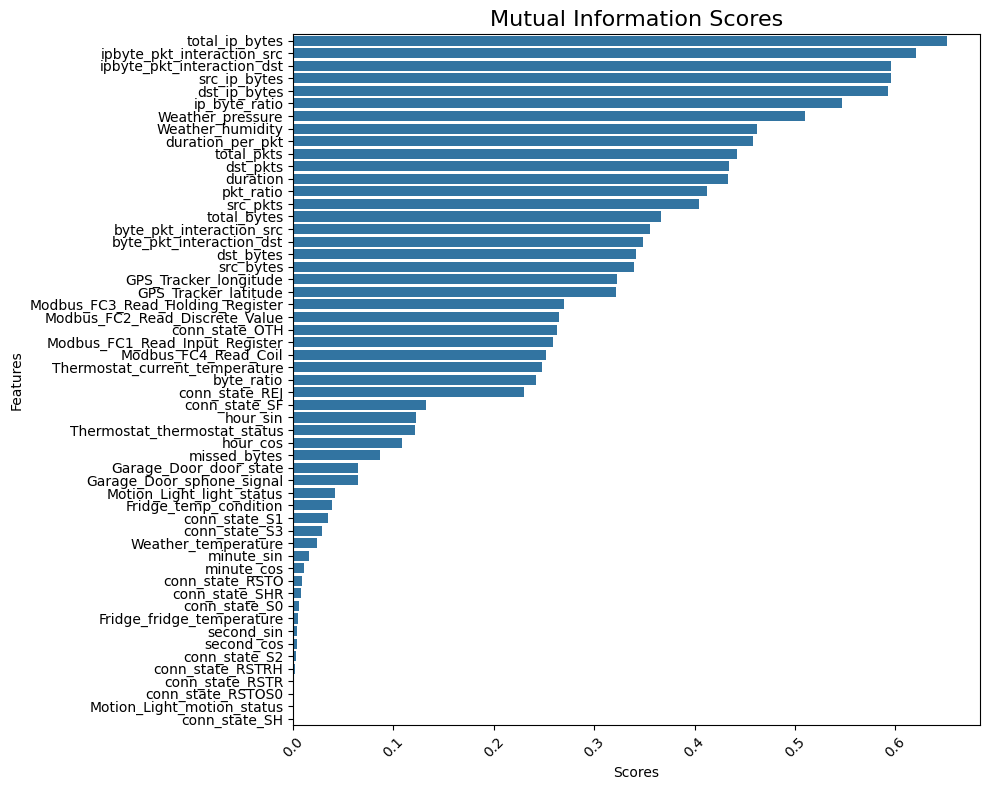

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(10, 8))

# Create the barplot
sns.barplot(x='Scores', y='Features', data=mi_scores)

# Add a title
plt.title("Mutual Information Scores", fontsize=16)

# Rotate the y-axis labels (if needed)
plt.yticks(rotation=0)

# Rotate the x-axis labels (if needed)
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()  # Adjusts the plot to ensure everything fits without overlap
plt.savefig("FeaturesMutualInformationScores.png")
plt.show()

In [86]:
x.drop(low_score_feature_names,axis=1, inplace = True)

In [87]:
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)
print("Data scaled successfully. Shape:", x_scaled.shape)

Data scaled successfully. Shape: (534901, 43)


**PCA**

In [88]:
# pca = PCA()
# pca.fit(x_scaled)  # x_scaled is your training data
# explained_variance_ratio = pca.explained_variance_ratio_
# cumulative_variance_ratio = explained_variance_ratio.cumsum()

# plt.plot(cumulative_variance_ratio)
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.show()

In [89]:
# # Determine optimal number of components for 95% variance
# n_components_95 = np.argmax(cumulative_variance_ratio >= 0.95) + 1
# print(f"Number of components for 95% variance: {n_components_95} out of {len(explained_variance_ratio)}")

# # Create more informative visualization
# plt.figure(figsize=(12, 5))

# # Plot 1: Cumulative variance
# plt.subplot(1, 2, 1)
# plt.plot(cumulative_variance_ratio, marker='o', linestyle='-', color='b')
# plt.axhline(y=0.95, color='r', linestyle='--', alpha=0.5)
# plt.text(n_components_95, 0.96, f'95% variance: {n_components_95} components', 
#          verticalalignment='bottom', horizontalalignment='center')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.title('Cumulative Explained Variance by Components')
# plt.grid(True, alpha=0.3)

# # Plot 2: Individual variance (scree plot)
# plt.subplot(1, 2, 2)
# plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
# plt.xlabel('Principal Component')
# plt.ylabel('Explained Variance Ratio')
# plt.title('Scree Plot')
# plt.grid(True, alpha=0.3)

# plt.tight_layout()
# plt.show()

# # Optional: Transform data to optimal components
# x_pca = pca.transform(x_scaled)
# x_pca_optimal = x_pca[:, :n_components_95]  # Use only components needed for 95% variance
# print(f"Original data shape: {x_scaled.shape}, Reduced data shape: {x_pca_optimal.shape}")

In [90]:
# # Binary Classification
# # Save X_scaled (assuming it's a NumPy array)
# pd.DataFrame(x_scaled).to_csv("x_scaled_binary_mi_s.csv", index=False)

# # Save y_label (can be a NumPy array or Series)
# pd.DataFrame(y, columns=["label"]).to_csv("y_label_mi_s.csv", index=False)
# print("All data saved as CSV:")
# print("- x_scaled -> 'x_scaled.csv'")
# print("- y -> 'y_label.csv'")


# Multi-Class Classification
# Save X_scaled (assuming it's a NumPy array)
pd.DataFrame(x_scaled).to_csv("x_scaled_multi_mi_s.csv", index=False)

# Save y_type (can be a NumPy array or Series)
pd.DataFrame(y, columns=["type"]).to_csv("y_type_mi_s.csv", index=False)
print("All data saved as CSV:")
print("- x_scaled -> 'x_scaled.csv'")
print("- y -> 'y_type.csv'")

All data saved as CSV:
- x_scaled -> 'x_scaled.csv'
- y -> 'y_type.csv'
